# SVM支持向量机

此教程分为两个部分: 

    第一个部分旨在使用可视化的方式让同学们理解SVM的工作原理, SVM分割线, SVM的支持向量. 并且使用实例证明SVM的分割线只由支持向量唯一确定, 与线性回归/逻辑回归不一样, SVM对异常数据具有较强的鲁棒性.

第二个部分展示了如何使用支持向量机实现人脸的分类识别. 对输入的人脸图像, 使用PCA(主成分分析)将图像(看作一维向量)进行了降维处理, 然后将降维后的向量作为支持向量机的输入. PCA降维的目的可以看作是特征提取, 将图像里面真正对分类有决定性影响的数据提取出来.

# 理解SVM

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
sns.set()

## 创建模拟数据集

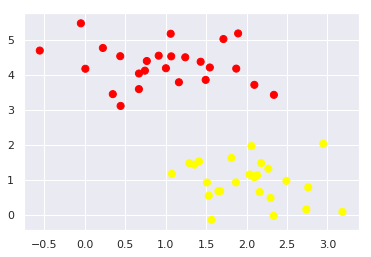

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2
                  , random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

## 多种方法分类

(-1, 3.5)

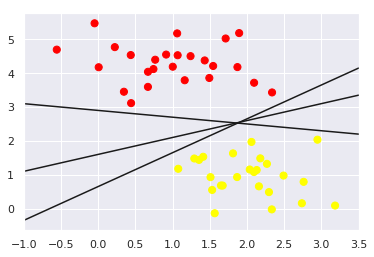

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
    
plt.xlim(-1, 3.5)

## SVM: 假想每一条分割线是有宽度的

(-1, 3.5)

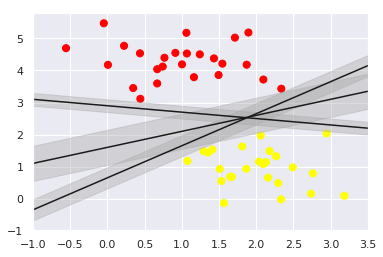

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit-d, yfit + d, edgecolor='none', 
                    color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

在SVM 框架下， 认为最宽的线为最优的分割线

## 训练 SVM

In [5]:
# 使用线性 SVM 和比较大的 C
# "Support vector classifier"
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## 创建一个显示SVM分割线的函数

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """
    绘制 2D SVC 决策边界的函数
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建网格来 评估 模型
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 绘制决策边界和边距
    ax.contour(X, Y, P, colors='k',
              levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])
    
    # 绘制支持向量机
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                  model.support_vectors_[:, 1],
                  s=300, linewidth=1, facecolors='none')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

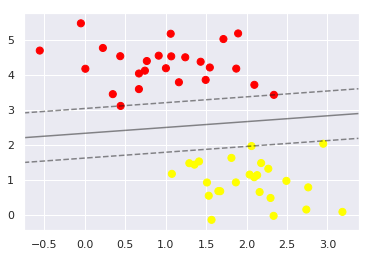

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

## 非支持向量的数据，对分割线没有影响
只有支持向量会影响分割线，如果我们添加一些非支持向量的数据，对分割线没有影响

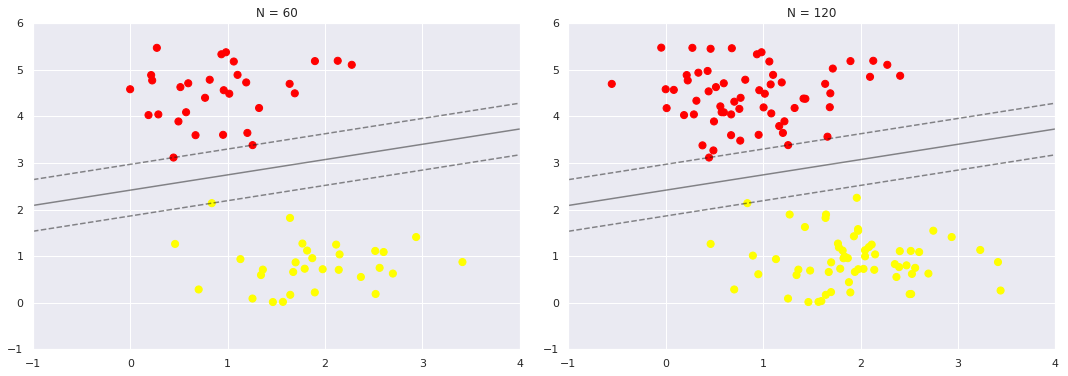

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples = 200, centers=2
                      ,random_state=0, cluster_std=0.60)
    
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

## 使用 SVM 进行人脸识别

In [9]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Junichiro Koizumi' 'Tony Blair']
(1041, 62, 47)


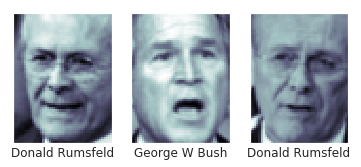

In [10]:
fig, ax = plt.subplots(1, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
           xlabel=faces.target_names[faces.target[i]])

每一幅图的尺寸为 [62×47] , 大约 3000 个像素值

我们可以将整个图像展平为一个长度为3000左右的一维向量, 然后使用这个向量做为特征. 通常更有效的方法是通过预处理提取图像最重要的特征. 一个重要的特征提取方法是PCA(主成分分析), 可以将一副图像转换为一个长度为更短的(150)向量.

In [11]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

## 将数据分为训练和测试数据集

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                               random_state=42)

## 调参：通过交叉验证寻找最佳的 C (控制间隔的大小)

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/home/bishi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 9.42 s, sys: 215 ms, total: 9.63 s
Wall time: 1.66 s
{'svc__C': 1}


In [14]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5, 0.98, 'predicted red error')

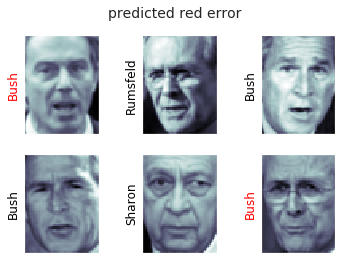

In [15]:
## 使用训练好的 SVM 做预测
fig, ax = plt.subplots(2, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                  color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('predicted red error', size=14)

## 生成性能报告

In [16]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                           target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.67      0.76        21
  Donald Rumsfeld       0.57      0.88      0.70        26
    George W Bush       0.90      0.88      0.89       140
Gerhard Schroeder       0.73      0.76      0.74        21
Junichiro Koizumi       0.69      1.00      0.82         9
       Tony Blair       0.94      0.73      0.82        44

         accuracy                           0.83       261
        macro avg       0.79      0.82      0.79       261
     weighted avg       0.85      0.83      0.83       261



## 混淆矩阵

Text(89.18, 0.5, 'predicted label')

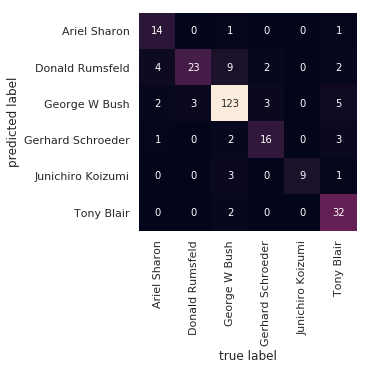

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=faces.target_names,
           yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

## SVM 总结

### 优点
- 模型只需要保存支持向量，模型占用内存少， 预测快
- 分类只取决于向量，适合数据维度高的情况，例如 DNA 数据

### 缺点
- 训练的时间复杂度为 $\mathcal{0}{N^3}$ 或者至少 $\mathcal{0}{N^2}$, 当数据量巨大